# Object Classification on Segmented Images

 - __Segmentation Method:__ Compact Watershed

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers

In [2]:
# load train/test dataset
X_train = np.load('drive/MyDrive/app/data/X_train_cw.npy', allow_pickle=True)
Y_train = np.load('drive/MyDrive/app/data/Y_train_cw.npy', allow_pickle=True)
X_test = np.load('drive/MyDrive/app/data/X_test_cw.npy', allow_pickle=True)
Y_test = np.load('drive/MyDrive/app/data/Y_test_cw.npy', allow_pickle=True)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, shuffle = True)

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [5]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [6]:
# load classes from python file resnet_18.py
from drive.MyDrive.app.resnet_18 import ResNet18

model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  74368     
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple          

In [7]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")

STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, 
                    batch_size = 256, epochs=50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
156/156 [==============================] - 54s 123ms/step - loss: 2.1750 - accuracy: 0.2757 - val_loss: 4.7063 - val_accuracy: 0.0997
Epoch 2/50
156/156 [==============================] - 18s 117ms/step - loss: 1.5630 - accuracy: 0.4339 - val_loss: 5.9577 - val_accuracy: 0.0996
Epoch 3/50
156/156 [==============================] - 18s 118ms/step - loss: 1.4176 - accuracy: 0.4870 - val_loss: 6.0180 - val_accuracy: 0.0997
Epoch 4/50
156/156 [==============================] - 18s 116ms/step - loss: 1.3386 - accuracy: 0.5187 - val_loss: 3.0650 - val_accuracy: 0.1414
Epoch 5/50
156/156 [==============================] - 18s 116ms/step - loss: 1.2467 - accuracy: 0.5509 - val_loss: 3.5918 - val_accuracy: 0.1307
Epoch 6/50
156/156 [==============================] - 18s 117ms/step - loss: 1.1796 - accuracy: 0.5809 - val_loss: 8.3201 - val_accuracy: 0.0998
Epoch 7/50
156/156 [==============================] - 18s 116ms/step - loss: 1.1176 - accuracy: 0.6016 - val_loss: 3.4557 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


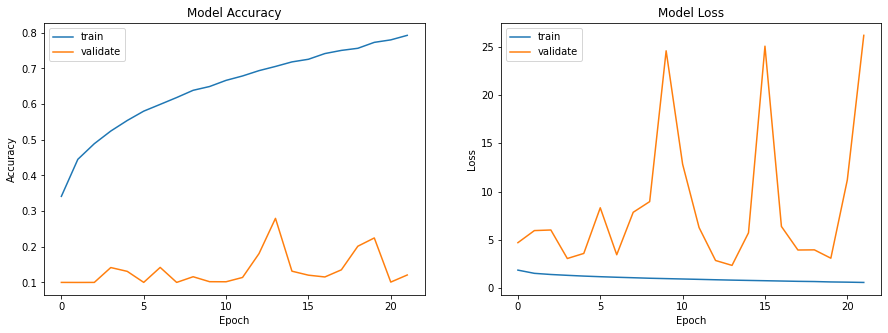

In [8]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [9]:
ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 9s 7ms/step - loss: 2.2930 - accuracy: 0.2852
Model Loss is 2.293039560317993
Model Accuracy is 0.28519999980926514


In [10]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, Y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 2s 7ms/step - loss: 2.3296 - accuracy: 0.2791
Model Loss is 2.3295862674713135
Model Accuracy is 0.2791000008583069


In [11]:
# save model's weights
model.save_weights('drive/MyDrive/app/resnet_18_cw.h5')